# Solving combinatorial optimization problems using QAOA

In this tutorial, we will:
- introduce combinatorial optimization problems,
- explain approximate optimization algorithms,
- explain how the Quantum Approximate Optimization Algorithm (QAOA) works,
- and run a simple example on a simulator or a real quantum system.

## Combinatorial Optimization Problem

Combinatorial optimization problems involve finding an optimal object out of a finite set of objects. We would focus on problems that involve finding "optimal" bit strings composed of 0's and 1's among a finite set of bit strings. One such problem corresponding to a graph is the Max-Cut problem.

### Max-Cut problem

Max-Cut 문제는 그래프의 노드를 집합 간 간선의 수가 최대가 되도록 두 집합으로 묶는 것을 포함합니다. 아래의 예제에는 4개의 노드를 가진 그래프와 아래에 보인 "빨강" 및 "파랑" 처럼 두 집합으로 묶을 수 있는 방법이 있습니다.

![](images/qaoa_maxcut.svg)

노드가 4개인 경우 각각의 노드를 "빨강" 또는 "파랑" 집합으로 할당할 수 있습니다.  집합은 $2^4=16$ 개가 가능하며, 이 중에서 집합 "빨강" 및 "파랑" 사이에 간선의 수가 가장 많은 집합을 찾아야 합니다. 그림에 있는 두 집합 간에 이러한 간선의 수는 왼쪽에서 오른쪽으로 0, 2, 2, 4 개 입니다. 확인할 수 있는 것처럼 모든 $2^4=16$ 개의 경우를 나열해 보면 가장 우측 그림이 두 집합 간의 간선의 수가 최대인 경우입니다. 따라서 "빨강"을 0 으로 "파랑"을 1로 부호화하면 두 집합으로 노드의 할당을 나타내는 비트열 "0101" 및 "1010" 은 정답이 됩니다. 

눈치채셨을 수도 있지만, 그래프의 꼭짓점 수가 증가하면 솔루션을 찾기 위해 검사해야 하는 가능한 할당의 수가 기하급수적으로 증가합니다.

## QAOA

Farhi 외 3인[1]이 도입한 QAOA(Quantum Approximate Optimization Algorithm)는 위에 소개한 것과 같은 조합 문제를 해결하기 위해 제시된 양자 알고리즘입니다.<br>

QAOA는 $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ 라는 매개변수를 갖는 유니타리 행렬 $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ 을 이용해 $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ 라는 양자 상태를 만드는 변분(variational) 알고리즘입니다. 이 알고리즘의 목표는 양자 상태 `{latex} \lvert \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle` 가 문제에 대한 해답을 표현하게 만드는 최적의 파라미터 `{latex} (\boldsymbol{\beta}_{\text{opt}} 와 <code data-md-type="codespan">{latex} \lvert \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle` 를 찾는 것입니다.

유니타리 행렬 $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ 는 특수한 형태를 가지고 있으며 $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ 와 $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$ 라는 두 부분으로 나눠집니다. 여기서 $H_B$ 는 혼합 해밀토니안이고 $H_P$ 는 문제 해밀토니안입니다. 유니타리 행렬의 이러한 형태는 양자 어닐링이라는 또 하나의 양자 알고리즘에서 유래한 것입니다.

초기 양자 상태 $\lvert \psi_0 \rangle$ 에 위에 설명한 두 유니타리 행렬을 $p$ 번 번갈아 적용하여 아래와 같은 양자 상태를 생성합니다.

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}}
\lvert \psi_0 \rangle$$

where $\lvert \psi_0 \rangle$ is a suitable initial state.

We will demonstrate these steps using the Max-Cut problem discussed above. For that we would first define the underlying graph of the problem shown above.

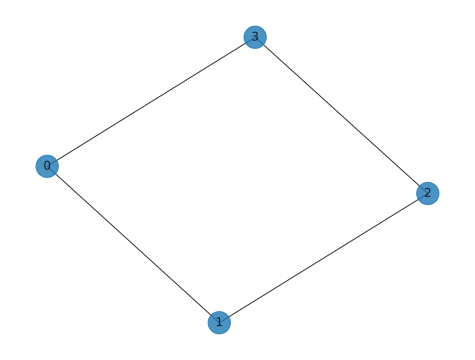

In [1]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

The problem Hamiltonian specific to the Max-Cut problem up to a constant here is:

$$
H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) +
        \frac{1}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) +
        \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) +
        \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big)
$$

문제에 맞는 해밀토니안을 만들기 위해서 다음과 같은 몇 단계를 따릅니다. 자세한건 나중에 설명합니다.

혼합 해밀토니안 $H_B$ 는 대개 아래와 같은 형태를 가집니다.

$$
H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) +
      \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big)
$$

As individual terms in the summation of $H_P$ and $H_B$ both commute, we can write the unitaries as:

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

Notice that each term in the product above corresponds to an X-rotation on each qubit. And we can write $U(H_P)$ as:

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

이제 각 유니타리 행렬을 구현하는 양자 회로가 어떻게 생겼는지 살펴봅시다. 

### 혼합 유니타리

/var/folders/z_/6s4ntyps5lsb232v7f82201r0000gn/T/ipykernel_64520/2153888928.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(graph).todense()


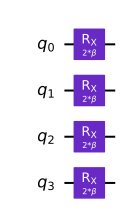

In [2]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw()

### 문제 유니타리

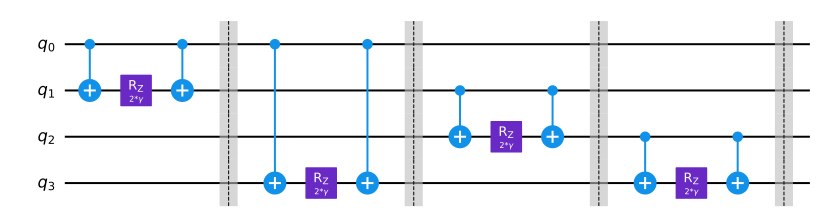

In [3]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw()

### The Initial State

The initial state used during QAOA is usually an equal superposition of all the basis states i.e.

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

모든 기저 상태의 균일한 중첩 상태를 만들기 위해서는 아래 회로와 같이 전부 0인 상태에서 하다마드 게이트를 적용하면 됩니다. 

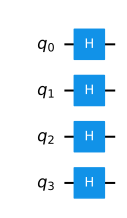

In [4]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw()

### The QAOA circuit

So far we have seen that the preparation of a quantum state during QAOA is composed of three elements

- Preparing an initial state
- 문제 해밀토니안에 해당하는 유니타리 행렬 `{latex} U(H_P) = e^{-i \gamma H_P}` 적용하기
- 혼합 유니타리 행렬 `{latex} U(H_B) = e^{-i \beta H_B}` 적용하기

Let's see what it looks like for the example problem:

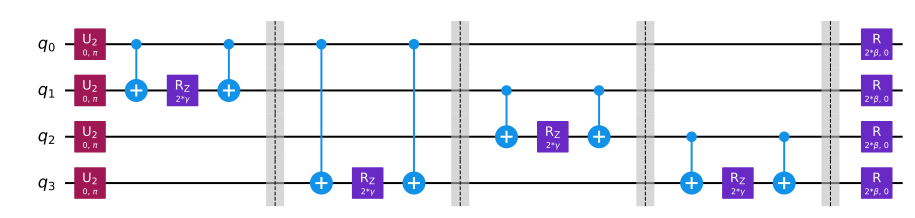

In [5]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw()

The next step is to find the optimal parameters `{latex} (\boldsymbol{\beta_{\text{opt}}}, \boldsymbol{\gamma_{\text{opt}}})` such that the expectation value

$$ \langle \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rvert H_P \lvert
\psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle $$

is minimized. Such an expectation can be obtained by doing measurement in the Z-basis. We use a classical optimization algorithm to find the optimal parameters. Following steps are involved as shown in the schematic


<img src="images/QAOA_schematic.png" width="400" height="200" class="center">

1. $\boldsymbol{\beta}$ 및 $\boldsymbol{\gamma}$ 를 적절한 실수 값으로 초기화
2. 적절한 수렴 조건이 만족할 때 까지 반복
    1. QAOA 회로를 사용하여 $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ 상태 준비
    2. 표준 기저로 상태 측정
    3. $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $ 계산
    4. 고전 최적화 알고리즘을 이용하여 새로운 매개변수 집합 `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})` 찾기
    5. 현재 매개변수$(\boldsymbol{\beta}, \boldsymbol{\gamma})$를 새로운 매개변수 `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})` 로 설정

아래 코드는 위에 언급한 단계를 구현한 것입니다.

In [6]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    # pylint: disable=invalid-name
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [7]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

Qiskit에는 다양한 클래식 옵티마이저가 있습니다. 여기서는 기존 최적화 알고리즘으로 [COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py) 를 선택합니다.

### 결과 분석

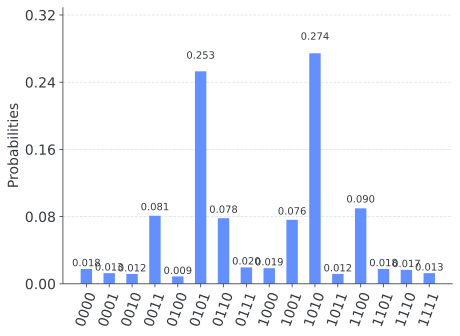

In [8]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

비트열 "0101" 및 "1010"이 가장 높은 확률을 가지며 실제로 두 묶음 사이에 4개의 간선이 있는 그래프의 할당임을 알 수 있습니다. 

## 부록

### 1. 문제 해밀토니안 만들기<a id="Constructing Hamiltonian"></a>

모든 최대화 문제는 최소화 문제로 나타낼 수 있으며, 그 반대도 유효합니다. 따라서 조합 최적화 문제의 일반적인 형태는 다음과 같습니다.

$$ \text{maximize } \;\;      C(x)$$

$$ \text{subject to } \;\; x \in S $$

여기서 $x \in S$는 이산 변수이고 $C : D \rightarrow \mathbb{R}$는 일부 도메인 $S$에서 실수 $\mathbb{R}$로 매핑되는 비용 함수입니다. 변수 $x$는 제약조건을 따를 수 있으며 가능한 점들의 집합 $S \subset D$ 안에 있습니다.

이진 조합 최적화 문제에서 비용 함수 $C$는 일반적으로 문자열 $x \in {0,1}^n$ 에 있는 $n$ 비트의 부분집합 $Q \subset[n]$만 포함하는 항의 합으로 표현할 수 있으며 다음과 같은 정규형(canonical form)으로 쓸 수 있습니다.

$$ C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \prod_{i\in Q} x_i \; \prod_{j\in \overline{Q}} (1- x_j), $$

여기서 $x_i \in {0,1}$ 와 $w_{(Q,\overline{Q})}\in \mathbb{R}$ 입니다. $C(x)$가 최대로 되는 n 비트열 $x$를 찾고자 합니다.

#### 1.1 대각 해밀토니안

이 비용함수는 계산 기저에서 대각인 헤밀토니안으로 매핑할 수 있습니다. 비용함수 $C$에 대한 헤밀토니안은 다음과 같이 쓸 수 있습니다.

$$ H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x| $$

여기서 $x \in {0,1}^n$은 계산 기저 상태 $|x \rangle \in \mathbb{C}^{2^n}$에 라벨을 붙입니다(??). 비용 함수가 최대 가중치 $k$ 항만 갖는 경우 즉, 최대 $Q \leq k$ 비트를 포함하는 $Q$만 기여하는 경우 이 대각 헤밀토니안은 또한 가중치 $k$ 파울리 Z 연산자의 합일 뿐입니다.

파울리 $Z$ 연산자로 $H$를 확장하는 것은 모든 이진 변수 $x_i \in {0,1}$ 행렬 `{latex} x_i \rightarrow 2^{-1}(1 - Z_i)`를 대체하여 비용 함수 $C$의 정규표현에서 얻을 수 있습니다. 여기서 $Z_i$는 파울리 $Z$ 연산자가 되며 큐비트 $i$에 작용하고 다른 것에는 당연합니다. 즉,

$$ Z_i = \left(\begin{array}{cc} 1 &amp; 0 \\ 0 &amp; -1 \end{array}\right). $$

이는 고전 비용 함수를 부호화하는 스핀 헤밀토니안을 파울리 $Z$만 포함하는 국부 양자 스핀 헤밀토니안 $|Q|$ 연산자로 표현할 수 있음을 의미합니다.

$$ H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) \; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$$

이제 소수의 ($n$에서 다항식으로 다수) $w_{(Q,\overline{Q})}$는 0이 아닌 것으로 가정합니다. 게다가 집합 $|(Q,\overline{Q})|$는 경계가 있고 너무 크지 않다고 가정합니다. 이는 $m$ 국부 항 $\hat{C}_k$의 합으로 헤밀토니안 $H$와 비용함수를 표현할 수 있음을 의미합니다.

```
$$ H = \sum_{k = 1}^m \hat{C}_k, $$
```

여기서 $m$과 $\hat{C}_k$는 경계가 있습니다.

### 2 예제: <a id="examples"></a>

조합 최적화 문제를 설명하기 위해 두 가지 예를 듭니다. Qiskit으로 첫 번째 예제만 구현하지만 일련의 연습을 통해 두 번째 예제를 구현하는데 도움이 되는 지침을 얻을 수 있습니다.

#### 2.1 (가중치가 있는) $MAXCUT$

$n$ 노드가 있는 무방향 그래프  *G = (V, E)*를 고려합니다. 여기서 *|V| = n*은 $(i,j)\in E$에 대해 ` $w_{ij}=w_{ji}$ `, $w_{ij}&gt;0$인 간선 가중치를 갖습니다. 컷은 원래 집합 V를 두 부분 집합으로 나누는 것으로 정의합니다. 이 경우 최적화할 비용 함수는 컷을 *교차하는* 서로 다른 두 하위 집합의 점을 연견=결하는 간선의 가중치의 합이 됩니다. $x_i=0$ 또는 $x_i=1$를 각 노드 $i$에 할당함으로써 전체 이익 함수(여기와 다음 합은 번호 1,2,...,n에 대해 수행됨)를 최대화합니다.

```
$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$
```

표기법을 단순화하기 위해 $(i,j) \in E$에 대해 균일 가중치 $ w_{ij} = 1$로 가정합니다. 양자 컴퓨터에서 이 문제에 대한 해결책을 찾으려면 먼저 위에서 설명한 것처럼 위 식을 대각 해밀토니안으로 매핑해야 합니다. 집합 $E$의 간선에 대한 합으로 합을 적습니다.

```
$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j)  = \sum_{(i,j) \in E} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$
```

이 식을 스핀 해밀토니안으로 매핑하기 위해 `{latex} x_i\rightarrow (1-Z_i)/2` 를 할당합니다. 여기서 $Z_i$는 고유값이 $\pm 1$인 파울리 Z 연산자이고 $C(\textbf {x}) \rightarrow H$ 입니다.

```
$$ H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_j Z_k \right).$$
```

이는 해밀토니안을 $m = |E|$ 국소 항의 합으로 나타낼 수 있음을 의미합니다.

$$\hat{C}_e = \frac{1}{2}\left(1 - Z_&lt;e&gt;Z_&lt;e&gt;\right)$$

여기서 $e = (e1,e2) \in E$ 입니다.

#### 2.2 제약 충족 문제와 $\text{MAX 3-SAT}$.

조합 최적화 문제의 또 다른 예는 $\text{3-SAT}$입니다. 여기서 비용 함수 `{latex} C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})` 는 절 $c_k(\textbf{x})$의 합입니다. 절은 일부 $\textbf{x} \in {0,1}^n$의 3비트 값을 제한합니다. $\text{3-SAT}$ 절의 예를 고려합니다.

$$ c_1(\textbf{x}) = (1-x_1)(1-x_3)x_{132} $$

위 식은 비트열 $\textbf{x} \in {0,1}^{133}$에 관한 것입니다. $x_1 = 0$, $x_3 = 0$, $x_{132} = 1$ 비트를 설정하면 이 절은 충족됩니다. $\text{3-SAT}$ 문제는 이제 모든 $m$ 절을 만족하는 비트열이 있는지 또는 그러한 문자열이 존재하지 않는지를 구합니다. 이러한 결정 문제는 $NP$ 완전 문제의 대표적인 예 입니다.

가장 비슷한 최적화 문제 $\text{MAX 3-SAT}$는 $C(\textbf{x})$에서 절의 최대 수를 만족하는 비트열 $\textbf{x}$를 찾도록 합니다. 물론 이것은 $m$ 절의 $\tilde{m}$ 이상을 만족하는 비트열이 어디에 있는지 요청하면 다시 $NP$ 완전한 결정 문제가 됩니다.

### 3. 최적화 알고리즘 근사화 <a id="approximateOPT"></a>

전에 고려한 $MAXCUT$ 및 $\text{MAX 3-SAT}$ 문제는 실제로 NP 난해 문제입니다 [3](#references). 실제로 많은 조합 최적화 문제는 일반적으로 계산적으로 해결하기 어렵다는 것이 밝혀졌습니다. 이러한 사실에 비추어 볼 때 이러한 문제를 다항식 실행 시간내에 해결하는 효율적인 알고리즘을 찾을 수 없을 것입니다. 이것은 양자 알고리즘에도 적용됩니다. 이러한 문제를 처리하는 데는 두 가지 주요 접근 방식이 있습니다. 첫 번째 방식은 다항식 시간에 지정된 품질의 해결책을 찾는 근사 알고리즘입니다. 두 번째 방식은 다항식 시간을 보장하지 못하지만 이와 비슷한 문제에서 잘 수행되는 휴리스틱 알고리즘입니다.

근사 최적화 알고리즘은 효율적이며 근사 솔루션이 문제의 실제 최적해에 얼마나 가까운지 보장할 수 있습니다. 이러한 보장은 일반적으로 근사 비율 $\alpha \leq 1$의 형태입니다. 확률적 근사 최적화 알고리즘은 비트열 $\textbf{x}^* \in {0,1}^n$을 생성하여 *높은 확률*로 양의 `{latex} C_\text{max} = \max_{\textbf{x}}C(\textbf{x})` 를 갖습니다.

$$ C_\text{max} \geq C(\textbf{x}^*) \geq \alpha C_\text{max}. $$

$MAXCUT$ 문제의 경우 Goemans 및 Williamson [2](#references)이 발명한 유명한 근사 알고리즘이 있습니다. 이 알고리즘은 $\alpha \approx 0.878$의 근사 비율을 갖는 높은 확률의 근사 해법 $\textbf{x}^*$을 만드는 확률 반올림 기술과 결합된 원래 문제의 SDP 완화를 기반으로 합니다. 이 근사 비율은 실제로 최적이므로 양자 알고리즘을 활용해도 개선되지 않습니다.

<!-- vale QiskitTextbook.SentenceLengthErr = NO -->

### 4. QAOA 알고리즘 <a id="QAOA"></a>

Farhi, Goldstone, Gutmann [1](#references) 가 제안한 양자 근사 최적화 알고리즘(Quantum Approximate Optimization Algorithm, QAOA)는 휴리스틱 알고리즘의 한 예입니다. Goemans-Williamson 알고리즘과 달리 QAOA는 성능을 보장하지 않습니다. QAOA는 고전 근사 알고리즘의 접근 방식을 취하고 높은 확률로 좋은 근사 비율 $\alpha$를 가질 것으로 예상되는 고전적인 비트열 $x^*$를 생성하는 양자 아날로그를 찾습니다. 세부 사항을 논의하기 전에 먼저 이 접근 방식의 일반적인 아이디어를 제시하겠습니다.

#### 4.1 개요:

우리는 몇몇 실수 매개변수 $\vec{\gamma},\vec{\beta}를 따르는 양자 상태 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$를 찾고자 합니다. 양자 상태는 문제 헤밀토니안 $H$에 대해 기대값을 최대화하는 속성이 있습니다. 이 시험 상태에 대해  `{latex} F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle`를 최대화 하는 파라미터 $\vec{\gamma}^*,\vec{\beta}^*$ 를 구하고자 합니다.

이러한 상태와 이에 상응하는 매개 변수가 있으면 양자 컴퓨터에서 $|\psi_p(\vec{\gamma}^ *,\vec{\beta}^* )\rangle$ 상태를 준비하고 $Z$ 기저 `{latex} |x \rangle = |x_1,\ldots x_n \rangle` 로 상태를 측정하여 임의의 결과 $x^*$를 구합니다.

우리는 이 임의의 $x^*$가 높을 확률로 기대값 `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)` 에 가까운 비트열이 됩니다. 따라서 $M_p$가 $C_\text{max}$에 가깝다면 $C(x^*)$도 마찬가지입니다.

#### 4.2 QAOA 알고리즘 구성 요소

#### 4.2.1 QAOA 시험 상태 <a id="section_421"></a>

QAOA의 핵심은 양자 컴퓨터에서 준비하는 시험 상태 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$입니다. 이상적으로 우리는 이 상태가 문제 헤밀토니안 $H$에 대해 큰 기대값 `{latex} F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle`을 갖기를 바랍니다. Farhi [1](#references) 에서 시도 상태 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$는 단일 큐비트 파울리 $X$ 회전과 함께 문제 헤밀토니안 $H$로 구성됩니다. 즉, 다음과 같은 문제 헤밀토니안에 대해

$$ H = \sum_{k = 1}^m \hat{C}_k $$

계산 기저에서 대각과 횡단 필드 헤밀토니안

$$ B = \sum_{i = 1}^n X_i $$

시도 상태는 $p$ 교대 유니타리를 적용하여 준비합니다.

$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle^n $$

X |+\rangle = |+\rangle$ 에 대해 곱 상태 $|+\rangle^n$에 적용하여 준비합니다.

이 특정 가설풀이(ansatz)는 극한 `{latex} \lim_{p \rightarrow \infty} M_p = C_\text{max}` 를 취할 때 `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)` 에 대해 벡터 $\vec{\gamma}^ *,\vec{\beta}^* $에 대한 명시적 선택이 존재한다는 장점이 있습니다. 이는 시험 상태 $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$를 $H$와 횡단 필드 헤밀토니안  B$에 대한 단열 (adiabatic) 시간 변화를 Trotterizing 다음 상태로 보는 것입니다. 참조 [1](#references).

반대로 이 시험 상태의 단점은 일반적으로 너무 깊지 않은 양자 회로에서 생성된 상태가 필요하다는 것입니다. 여기서 깊이는 양자 칩에 직접 적용할 수 있는 게이트 수로 측정합니다. 따라서 참조 [4](#references), [5](#references)에서는 양자 칩의 하드웨어에 더 잘 맞는 가설풀이(ansatz) 시험 상태 사용을 제안합니다.

#### 4.2.2 기대값 계산<a id="section_422"></a>

이 접근 방식의 중요한 구성 요소는 기대값을 계산하거나 추정해야 한다는 것입니다.

$$
F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle
$$

$\vec{\gamma},\vec{\beta}$ 매개변수를 최적화할 수 있습니다. 여기서는 두 가지 시나리오를 고려할 것입니다.

#### 고전적인 계산

$|\psi_p(\vec{\gamma},\vec{\beta})\rangle$을 준비하는 회로가 너무 깊지 않은 경우 기대값 $F_p$를 고전적으로 계산할 수 있습니다.

이것은 예를 들어 경계 차수가 있는 그래프에 대해 $MAXCUT$을 고려하고 $p=1$인 회로를 고려할 때 발생합니다. 아래의 Qiskit 구현(섹션 5.2)에서 이에 대한 예를 들고 기대값을 계산하는 연습문제가 있습니다.

아이디어를 설명하기 위해 해밀토니안은 개별 항 `{latex} H = \sum_{k = 1}^m \hat{C}_k` 의 합으로 표현할 수 있음을 다시금 생각하십시오. 기대값의 선형성으로 인해 개별 합인자(summands)의 기대값을 고려하는 것으로 충분합니다. $p = 1$인 경우 기대값은 다음과 같습니다.

$$ \langle \psi_1(\vec{\gamma},\vec{\beta})|\hat{C}_k|\psi_1(\vec{\gamma},\vec{\beta})\rangle =  \langle +^n | e^{ i\gamma_1 H } e^{   i\beta_1 B } | \hat{C}_k |  e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+^n\rangle.$$

`{latex} B = \sum_{i = 1}^n X_i` 에 대해 유니타리 $e^{ -i\beta_1 B }$는 실제로 각도가 $\beta$인 $X$에 대한 단일 큐비트 회전의 곱임을 관찰할 수 있습니다. 단일 큐비트 회전은 `{latex} X(\beta)_k = \exp(i\beta X_k)` 로 쓸 수 있습니다.

$\hat{C}_k$가 지원되는 큐비트에서 작동하지 않는 모든 개별 회전은 $\hat{C}_k$로 이동하므로 취소됩니다. 이것은 연산자 $\hat{C}_k$의 지원을 증가시키지 않습니다. 이는 단일 게이트의 두 번째 세트 `{latex} e^{ -i\gamma_1 H } = \prod_{l=1}^m U_l(\gamma)` 큰 게이트 세트 `{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }` 를 가짐을 의미합니다. `{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }` 연산자 `{latex} e^{ i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B }` 포함합니다. 기대값에 기여하는 유일한 게이트 <code>{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }</code>는 원래 $\hat{C}_k$를 지원하는 큐비트를 포함하는 게이트입니다.

따라서 제한된 정도의 상호작용을 위해 `{latex} e^{ i\gamma_1 H } e^{   i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B } e^{ -i\gamma_1 H }`의 지원은 $H$의 상호 작용 정도에 따라 확장되는 시스템의 크기와는 무관합니다. 이는 이러한 더 작은 하위 문제의 경우 기대값이 $N$과 독립적이며 고전저으로 계산될 수 있음을 의미합니다. 참고문헌 [1](#references)에서는 일반적인 정도 $3$의 경우를 고려합니다.

이것은 일반적인 관찰입니다. 즉, 시험 상태를  준비하는 회로가 해밀턴의 각 항의 지원을 일정한 양만큼만 증가시키는 문제에 대해서는 비용 함수를 직접 계산할 수 있습니다.

시험 상태 준비에 몇 가지 매개 변수 $\beta, \gamma$만 필요한 경우 간단한 격자 검색으로 쉽게 찾을 수 있습니다. 또한 $\alpha$의 추정치를 얻기 위해 $M_p$의 정확한 최적 값을 사용하여 근사 비율을 제한할 수 있습니다.

$$ \frac{M_p}{C_\text{max}} \geq \alpha $$

이 경우 문제 크기따라 다항식 효율성으로 얻을 수 있는 근사 비율을 보장하는 기존의 근사 최적화 알고리즘과 QAOA 알고리즘은 동일한 특성을 갖습니다.

#### 양자 컴퓨터에서 계산

양자 회로가 고전적으로 계산하기에 너무 깊어지거나, 문제 헤밀토니안의 연결성이 너무 높을 때 우리는 기대값을 추정하는 다른 방법을 고려할 수 있습니다. 양자 컴퓨터에서 $F_p(\vec{\gamma},\vec{\beta})$를 직접 추정하는 방법이 있습니다. 여기서 접근 방식은 VQE (참고문헌 [4](#references)) 에서 사용되는 기존 기대값 추정의 과정을 따릅니다. 여기서 양자 컴퓨터에서 시험 상태 $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle$를 직접 준비하고 표본화하여 기대값을 구합니다.

QAOA에는 대각 해밀토니안 $H$이 있으므로 간단히 기대값을 추정할 수 있습니다. 계산 기저에 있는 시험 상태에서 표본을 구하기만 하면 됩니다. $H = \sum_{x \in {0,1}^n} C(x) |x \rangle\langle x|$를 기억하면 $Z$ 기저에 있는 $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$ 상태의 단일 큐비트 측정을 반복하여 다음과 같은 표본화 추정치를 얻을 수 있습니다.

$$ \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle = \sum_{x \in \{0,1\}^n} C(x) |\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$$

분포 $|\langle x|\psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ 에서 얻은 모든 비트열 $x$에 대해 비용 함수 $C(x)$를 계산하고 총 표본 수에 대해 평균을 냅니다. 경험적 평균 결과는 상태의 분산 내에 있는 부가성 표본화 오류치까지 기대값을 근사화합니다. 그 차이는 아래에서 논의할 것입니다.

기대값에 접근할 수 있으므로 이제 참고문헌 [6](#references) 과 같은 기존 최적화 알고리즘을 실행하여 $F_p$를 최적화할 수 있습니다.

이 접근 방식은 $x^*$에 대한 선험적 근사치 보장으로 이어지지 않지만 나중에 최적화된 함수 값을 사용하여 근사 비율 $\alpha$에 대한 추정치를 구할 수 있습니다.

#### 4.3.3 높은 확률로 주어진 근사 비율의 해법 구하기

이 알고리즘은 본질적으로 확률적이며 분포 $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$에 대해 무작위 비트열을 생성합니다. 그렇다면 최적화된 기대값 $M_p$에 가까운 근사값 $x^*$를 표본화할 것이라고 어떻게 확신할 수 있습니까? 이 질문은 애초에 양자 컴퓨터에서 $M_p$를 추정하는 것과도 관련이 있습니다. $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$에서 구한 표본의 분산이 너무 크면 평균을 결정하는 데 많은 표본이 필요합니다.

변수로서 에너지의 분산이 작을때 높은 확률로 평균 $M_p$에 가까운 비트열 $x^*$를 구할 것입니다.

헤밀토니안 `{latex} H = \sum_{k=1}^m \hat{C}_k`에 있는 항의 수는 $m$으로 제한됩니다. 각각의 개별 합인자 $\hat{C}_k$가 모든 $k = 1\ldots m$에 대해 범용 상수 $|\hat{C}_k|  \leq \tilde{C}$로 제한되는 연산자 노름을 갖습니다.

$$
\begin{aligned}
\langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle - \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle^2 &amp;\leq  \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle \\
&amp;= \sum_{k,l =1}^m  \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \\
&amp;\leq m^2 \tilde{C}^2 \\
\end{aligned}
$$

여기서 `{latex} \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \leq \tilde{C}^2`인 관계를 적용합니다.

이는 모든 기대값 $F_p(\vec{\gamma},\vec{\beta})$의 분산이 $m^2 \tilde{C}^2$로 제한됨을 의미합니다. 따라서 이것은 특히 $M_p$에 적용됩니다. 또한 $m$이 큐비트 $n$의 수에서 다항적으로만 증가하는 경우 다항적으로 증가하는 표본의 수 $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ 로 부터 $s = O\left(\frac{\tilde{C}^2 m^2}{\epsilon ^2}\right)$는 $M_p$에 가까운 $C(x^*)$에 이르는 $x^*$를 얻기에 충분합니다.

### 5. 연습문제<a id="problems"></a>

1. QAOA 알고리즘은 비트을 생성합니다. 이것이 이 그래프에 대한 최적의 해입니까? 초전도 칩의 실험 결과와 로컬 QASM 시뮬레이션의 결과를 비교하십시오.

2. [5.2 절](#implementation_sec52) 에서 분석적으로 비용 함수 $F_1$를 계산했습니다. 단계를 확인하고 $f_A(\gamma,\beta)$와 $f_B(\gamma,\beta)$를 계산합니다.

3. Qiskit 구현에서 $F_1$에 대한 정확한 표현이 있습니다.

    - 결과에서 얻은 표본에서 기대값 $F_1(\gamma,\beta)$를 추정하는 루틴을 작성하십시오.
    - 이 글의 VQE 예제에서 SPSA와 같은 최적화 루틴을 사용하여 표본화된 $F_1(\gamma,\beta)$의 매개변수를 수치적으로 최적화합니다. $\gamma^*,\beta^*$ 에 대해 동일한 값을 찾았습니까?

4. [5.3 절](#implementation_sec53) 의 시험 회로는 깊이 $p=1$에 해당하며 직접적으로 하드웨어와 호환되는 것을 목표로 했습니다.

    - 연습문제 2의 루틴을 사용하여 $p=2,3$에 대한 비용 함수 $F_p(\gamma,\beta)$를 계산합니다. 실제 하드웨어에서 무엇을 기대합니까?
    - 이 시험 상태 클래스를 참고문헌 [4](#references)의 하드웨어 효율적인 ansatz와 같은 다른 파동 함수로 일반화하십시오. 

## 참고문헌<a id="references"></a>

1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)

In [9]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table